# RNN (LSTM) code, just a example.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
df = pd.read_csv('air_data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)

In [3]:
df.drop('No', axis=1, inplace=True)
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'
df['pollution'].fillna(0, inplace=True)

In [4]:
df = df[25:]

In [5]:
#plt.figure(figsize=(10,10))

#columns = df.columns

#for i, column in enumerate(columns):
#    plt.subplot(len(columns), 1, i+1)
#    plt.plot(df[column])
#    plt.title(column, y=0.5, loc='right')

#plt.show()

In [6]:
encoder = LabelEncoder()

In [7]:
a = encoder.fit_transform(df['wnd_dir'])
df.loc[:, 'wnd_dir'] = a
del a

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
df = pd.DataFrame(scaled, columns = df.columns, index=df.index)

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [9]:
def time_shift(df, lags, dropnan=True):
    
    '''
    Adiciona novas colunas deslocadas no tempo.
    Argumentos:
        df: Pandas DataFrame.
        lags: lista com o número de passos
               a ser deslocado.
    Retorna:
        Pandas DataFrame com as colunas deslocadas.
    '''
    lags.append(0)
    lags = -1 * np.sort(lags)
    
    columns = list(df.name) if type(df) is pd.Series else df.columns
    col = []
    
    for column in columns:
        for lag in lags: 
            
            if lag == 0:
                new_column = column 
                col.append(new_column)
            else:
                new_column = column + '_lag(' + str(-1 * lag) + ')'
                col.append(new_column)
                df[new_column] = df[column].shift(lag)
                
    if dropnan:
        df.dropna(inplace=True)
    
    return df[col]

In [10]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0
2010-01-02 05:00:00,0.109658,0.485294,0.213115,0.563636,0.666667,0.011433,0.111111,0.0


In [11]:
df = time_shift(df, [-1])

In [12]:
df.drop(['dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain'], axis=1, inplace=True)

# Warning ==> Olha se a coluna de previsões tá sendo selecionada

In [13]:
# a coluna de previsão tem que estar na posiçao 0.
predic_col_id = 1
aux = df.columns[predic_col_id]
df.rename(columns={aux:df.columns[0], df.columns[0]:aux}, inplace=True)
df.head(1)

,pollution,pollution_lag(-1),dew_lag(-1),temp_lag(-1),press_lag(-1),wnd_dir_lag(-1),wnd_spd_lag(-1),snow_lag(-1),rain_lag(-1)
date,,,,,,,,,
2010-01-02 02:00:00,0.148893,0.15996,0.367647,0.245902,0.527273,0.666667,0.003811,0.0,0.0


In [14]:
one_year = 365 * 24
train = df.iloc[:one_year, :]
test = df.iloc[one_year:, :]
x_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
x_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]

In [15]:
# Reshape input to be 3D [samples, timesteps, features]
x_train = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.values.reshape((x_test.shape[0], 1, x_test.shape[1]))
y_test = y_test.values
y_train = y_train.values

In [16]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8760, 1, 8), (8760,), (35038, 1, 8), (35038,))

In [17]:
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [18]:
history = model.fit(x_train, y_train, epochs=50, batch_size=72, validation_data=(x_test, y_test), verbose=0, shuffle=False)

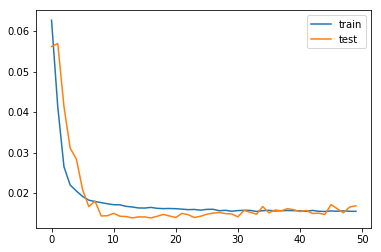

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [20]:
yhat = model.predict(x_test)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[2]))

In [21]:
yhat.shape, x_test[:, 1:].shape

((35038, 1), (35038, 7))

In [22]:
inv_yhat = np.concatenate((yhat, x_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [23]:
y_test = y_test.reshape((len(y_test), 1))

In [24]:
inv_y = np.concatenate((y_test, x_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [25]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 28.453


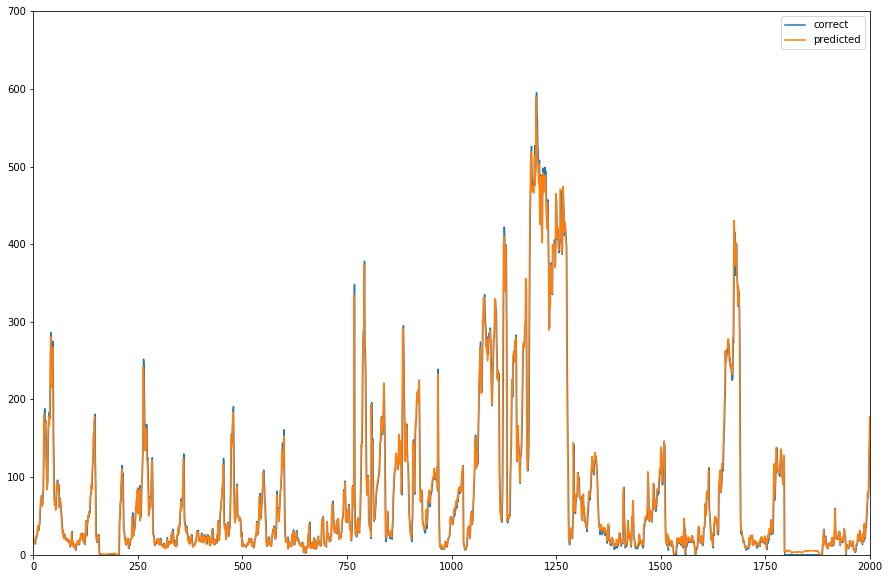

In [26]:
plt.figure(figsize=(15,10))
plt.plot(inv_y, label='correct')
plt.plot(inv_yhat, label='predicted')
plt.legend()
plt.xlim(0,2000)
plt.ylim(0,700)
plt.show()

In [27]:
df.head()

,pollution,pollution_lag(-1),dew_lag(-1),temp_lag(-1),press_lag(-1),wnd_dir_lag(-1),wnd_spd_lag(-1),snow_lag(-1),rain_lag(-1)
date,,,,,,,,,
2010-01-02 02:00:00,0.148893,0.159960,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2010-01-02 03:00:00,0.159960,0.182093,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0
2010-01-02 04:00:00,0.182093,0.138833,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0
2010-01-02 05:00:00,0.138833,0.109658,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0
2010-01-02 06:00:00,0.109658,0.105634,0.485294,0.213115,0.563636,0.666667,0.011433,0.111111,0.0
